In [ ]:
# 02_eda.ipynb
# Performs exploratory data analysis (EDA) on census tract-level data.

# Libraries
import sys
import pickle
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx
from pathlib import Path

sys.path.append(str(Path().resolve().parent / "src"))
from cleaning_functions import preview_df

# Paths
DATA_DIR = Path("../data/modeling/")


In [ ]:
## --- LOAD DATA ---
# Load from pickle file
with open(DATA_DIR / "gdf_tracts.pkl", "rb") as f:
    tracts = pickle.load(f)

In [ ]:
## --- SUMMARY STATISTICS AND PLOTS ---
# Summary statistics
display(tracts.describe(include='all'))

# Boxplot for all numeric variables
plt.figure(figsize=(16, 8))
tracts.select_dtypes(include=np.number).boxplot(rot=90)
plt.title("Boxplot of Numeric Variables")
plt.tight_layout()
plt.show()

# Histogram for all numeric variables
tracts.select_dtypes(include=np.number).hist(figsize=(18, 14), bins=30, layout=(6, 5))
plt.suptitle("Histograms of Numeric Variables", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

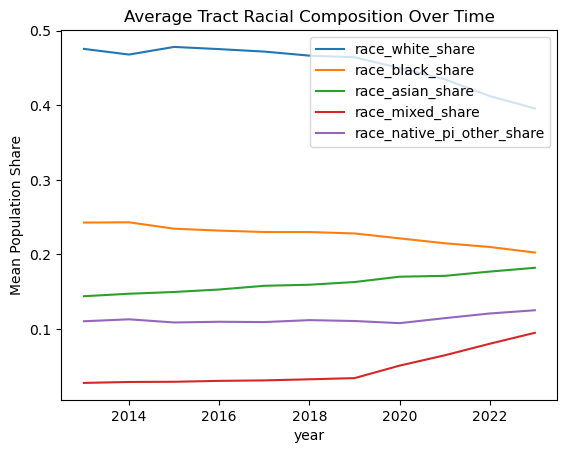

In [ ]:
# --- DEMOGRAPHIC DECOMPOSITION OVER TIME ---
# Plot race shares over time (aggregated)
race_shares = tracts.groupby("year")[
    [
        "race_white_share",
        "race_black_share",
        "race_asian_share",
        "race_mixed_share",
        "race_native_pi_other_share",
    ]
].mean()

race_shares.plot(title="Average Tract Racial Composition Over Time")
plt.ylabel("Mean Population Share")
plt.show()

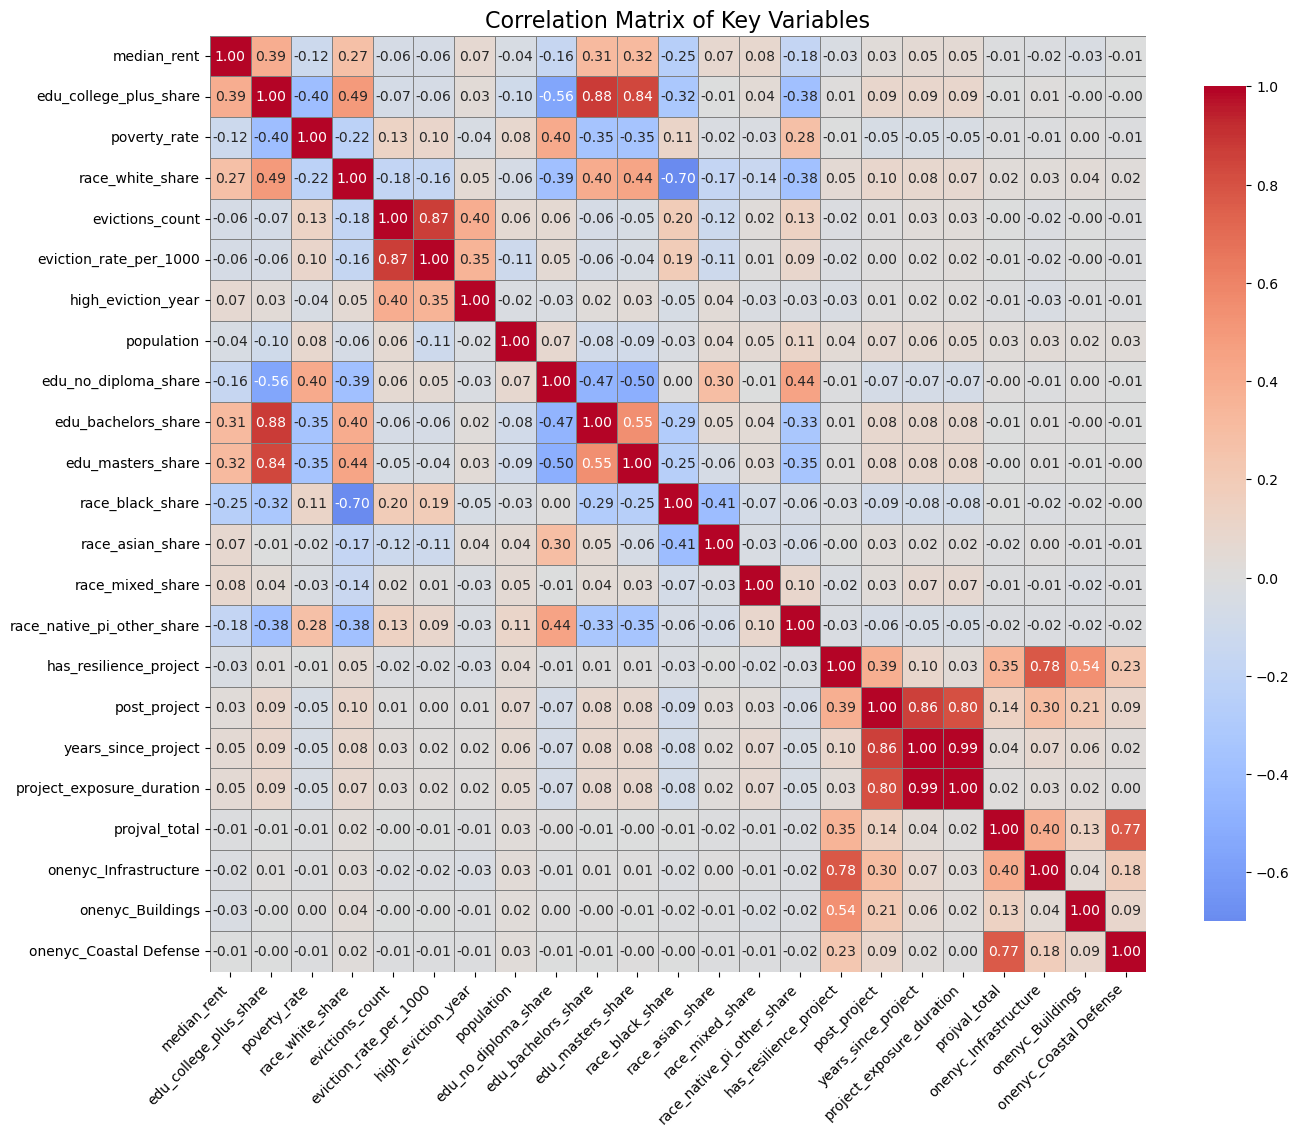

In [ ]:
# --- PAIR-WISE COORELATION ---

corr_cols = [
    # Gentrification outcomes
    "median_rent",
    "edu_college_plus_share",
    "poverty_rate",
    "race_white_share",
    # Eviction and displacement
    "evictions_count",
    "eviction_rate_per_1000",
    "high_eviction_year",
    # Demographic and education
    "population",
    "edu_no_diploma_share",
    "edu_bachelors_share",
    "edu_masters_share",
    # Race shares
    "race_black_share",
    "race_asian_share",
    "race_mixed_share",
    "race_native_pi_other_share",
    # Project/treatment indicators
    "has_resilience_project",
    "post_project",
    "years_since_project",
    "project_exposure_duration",
    "projval_total",
    "onenyc_Infrastructure",
    "onenyc_Buildings",
    "onenyc_Coastal Defense",
]

# Compute correlation matrix
corr = tracts[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5,
    linecolor="gray",
)

plt.title("Correlation Matrix of Key Variables", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
## --- Evictions and Resillience Projects by Census Tract ---
# Evictions + Resilience Overlay
resilience_gdf = tracts[tracts["has_resilience_project"] == 1]
norm = colors.Normalize(vmin=0, vmax=tracts["evictions_count"].max() * 0.8)

fig, ax = plt.subplots(figsize=(12, 10))
tracts.plot(
    ax=ax,
    column="evictions_count",
    cmap="Reds",
    legend=True,
    edgecolor="white",
    linewidth=0.2,
    norm=norm,
    missing_kwds={"color": "lightgrey", "label": "No Data"},
)
resilience_gdf.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=0.8,
    label="Resilience Project",
)
ax.set_title("Evictions by Census Tract with Resilience Exposure Overlay", fontsize=14)
ax.axis("off")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=11)

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()